In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [1]:
from utils import *
import pickle

mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq_fixed/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        (np.array([ts[i][order2[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts[i][order1[i]] for i in range(len(ts))]) - mu_t)/sd_t,
                                        (np.array([ts2[i][order2[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2,
                                        (np.array([ts2[i][order1[i]] for i in range(len(ts2))]) - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
    # with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "wb") as f:
    #     pickle.dump(x_array, f)

on ... 0 0 qq
on ... 0 0 qqq
on ... 0 0.5 qq
on ... 0 0.5 qqq
on ... 0 1 qq
on ... 0 1 qqq
on ... 0 1.5 qq
on ... 0 1.5 qqq
on ... 0 2 qq
on ... 0 2 qqq
on ... 0 2.5 qq
on ... 0 2.5 qqq
on ... 0 3 qq
on ... 0 3 qqq
on ... 0 3.5 qq
on ... 0 3.5 qqq
on ... 0 4 qq
on ... 0 4 qqq
on ... 0 4.5 qq
on ... 0 4.5 qqq
on ... 0 5 qq
on ... 0 5 qqq
on ... 0 5.5 qq
on ... 0 5.5 qqq
on ... 0 6 qq
on ... 0 6 qqq
on ... 0.5 0 qq
on ... 0.5 0 qqq
on ... 0.5 0.5 qq
on ... 0.5 0.5 qqq
on ... 0.5 1 qq
on ... 0.5 1 qqq
on ... 0.5 1.5 qq
on ... 0.5 1.5 qqq
on ... 0.5 2 qq
on ... 0.5 2 qqq
on ... 0.5 2.5 qq
on ... 0.5 2.5 qqq
on ... 0.5 3 qq
on ... 0.5 3 qqq
on ... 0.5 3.5 qq
on ... 0.5 3.5 qqq
on ... 0.5 4 qq
on ... 0.5 4 qqq
on ... 0.5 4.5 qq
on ... 0.5 4.5 qqq
on ... 0.5 5 qq
on ... 0.5 5 qqq
on ... 0.5 5.5 qq
on ... 0.5 5.5 qqq
on ... 0.5 6 qq
on ... 0.5 6 qqq
on ... 1 0 qq
on ... 1 0 qqq
on ... 1 0.5 qq
on ... 1 0.5 qqq
on ... 1 1 qq
on ... 1 1 qqq
on ... 1 1.5 qq
on ... 1 1.5 qqq
on ... 1 2 qq
on ... 1

In [13]:
import pickle
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
x = {}
with open("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", "rb") as f:
    x_array_read = pickle.load(f)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qq, False] = x_array_read[mycounter]

In [15]:
qq = "qq"

In [7]:
x[1,1, qq, False]

array([[-1.17673766, -1.56447832, -0.76455058, -1.08964067, -0.17336297,
         0.200626  ],
       [-1.36719485, -1.07154293, -0.91929118,  0.49800794, -1.29983736,
        -0.19974761],
       [-1.1053607 , -1.65199309, -0.67742992, -0.68213629, -1.17820181,
         0.3466491 ],
       ...,
       [-1.06977967, -1.6739351 , -1.74680612,  0.18046861, -3.17549976,
        -0.44647016],
       [-1.17702702, -1.73369464, -1.58980572,  0.1677468 , -2.92104951,
        -0.13177881],
       [-1.10853637, -1.64543869,  0.33738727, -0.08532435,  0.2606052 ,
        -3.2668104 ]])

In [18]:
np.shape(x_array[0])

(76373, 6)

In [5]:
test = np.load("W_q_100_100_high_level_features.npy", allow_pickle = True)
np.shape(test)

(76373, 6)

In [6]:
test

array([[0.150308  , 0.52540458, 0.78506277, 0.104488  , 0.28992314,
        0.69563436],
       [0.111077  , 0.40405614, 0.60229282, 0.104146  , 0.5344167 ,
        0.77031775],
       [0.139942  , 0.45214252, 0.51136438, 0.106988  , 0.27537547,
        0.6197377 ],
       ...,
       [0.118241  , 0.27804457, 0.61225863, 0.0993454 , 0.39046139,
        0.53739188],
       [0.101323  , 0.54995058, 0.77340149, 0.0967434 , 0.4528955 ,
        0.64811971],
       [0.105356  , 0.21591626, 0.76569951, 0.089513  , 0.15151533,
        0.75239603]])

In [5]:
qq = "qq"
qqq = "qqq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
def load_data(filename, noise_dims):

    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for q in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,q, False] = x_array_read[mycounter]

                if noise_dims and qq == "qq":
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
            
x = load_data("/pscratch/sd/g/gupsingh/x_array_fixed.pkl", noise_dims = 0)

In [6]:
qq

'qq'

In [7]:
qqq = "qqq"

In [6]:
x[1, 1, qq, False]

array([[-1.1467854 , -1.47770924, -0.06188168, -1.25308806,  0.34378257,
        -0.18466159],
       [-1.1487145 , -1.69706728, -0.68294717,  0.03500569, -1.06319069,
         0.43469069],
       [-1.13268386, -1.55028145, -1.34432782, -0.39714657, -0.953696  ,
        -1.60115472],
       ...,
       [-1.17579285, -1.62957953, -0.78923019, -1.31430044, -1.73511428,
        -0.82381764],
       [-1.19046974, -1.71033063, -0.4539729 ,  0.11360652, -0.80338618,
         0.44749405],
       [-1.23125368, -1.64679808, -1.99324816, -1.64119963, -0.33379286,
         0.3691295 ]])

In [28]:
np.shape(x[0,0, qq, True])

(121352, 16)

In [4]:
np.shape(x[0,0, qq, False])

(121352, 6)

In [44]:
np.shape(x[0,0, qqq, False])

(121352, 6)

In [24]:
x_data_qq = []
y_data_qq = []
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qq = np.concatenate([x_data_qq,x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([y_data_qq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [11]:
x_data_qqq = []
y_data_qqq = []
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qqq']:
            qq = "qqq"
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qqq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qqq = np.concatenate([x_data_qqq,x_aug_0,x_aug_m])
                y_data_qqq = np.concatenate([y_data_qqq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [29]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_fixed", x_data_qq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_fixed", y_data_qq)

In [9]:
# np.save("/pscratch/sd/g/gupsingh/x_parametrized_data_qqq_fixed", x_data_qqq)
# np.save("/pscratch/sd/g/gupsingh/y_parametrized_data_qqq_fixed", y_data_qqq)

In [129]:
# x_data_qq = np.load("/pscratch/sd/g/gupsingh/x_parametrized_data_qq_fixed.npy")
# y_data_qq = np.load("/pscratch/sd/g/gupsingh/y_parametrized_data_qq_fixed.npy")

In [131]:
x_data_qq = np.load("x_parametrized_data_qq_fixed.npy")
y_data_qq = np.load("y_parametrized_data_qq_fixed.npy")

In [132]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qq, y_data_qq, test_size=0.5, random_state = 42)

In [133]:
X_train_qq

array([[-1.29067761, -1.49584945,  1.523089  , ..., -0.33863646,
         3.        ,  4.5       ],
       [-0.9812558 , -0.0741258 , -1.56602011, ...,  0.2154482 ,
         1.        ,  4.        ],
       [-1.5053652 , -1.46572857,  2.1232833 , ...,  1.16977851,
         2.        ,  5.5       ],
       ...,
       [-1.33821732,  0.60248958, -0.35903133, ..., -0.80362504,
         5.5       ,  1.5       ],
       [-1.1929567 , -0.94234964, -0.89993095, ...,  0.49589514,
         3.5       ,  6.        ],
       [-1.21768687, -0.23171448, -0.45549635, ...,  0.50476543,
         5.5       ,  1.        ]])

In [12]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5, random_state = 42)

In [19]:
X_train_qqq

array([[-1.01357652, -1.73295289,  1.20862549, ...,  1.01502877,
         2.        ,  1.5       ],
       [-0.82867141,  1.29552367, -0.08583506, ..., -2.22494426,
         3.5       ,  3.5       ],
       [-1.13499651,  1.07107216, -0.36806473, ...,  0.89796848,
         1.        ,  6.        ],
       ...,
       [-1.45647626, -1.72667151,  1.86582934, ...,  1.60819248,
         5.5       ,  0.5       ],
       [-1.22105544,  1.56863124,  1.07320472, ...,  1.3650016 ,
         3.5       ,  5.5       ],
       [ 0.94213325, -1.13824551, -1.30352825, ..., -2.13668104,
         5.        ,  6.        ]])

In [11]:
# x_data_qqq = np.load("x_data_qqq.npy")
# y_data_qqq = np.load("y_data_qqq.npy")

In [383]:
np.shape(x_data_qq)

(27249420, 8)

In [ ]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from wandb.keras import WandbCallback

pscratch_dir = "/pscratch/sd/g/gupsingh/"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 128,
    "layer_3_neurons": 64,
    "output_neurons": 1,
    "activation": "relu",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.01,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh',
           mode = 'online',
           config=config)

config = wandb.config
run_name = wandb.run.name

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def train_parametrized(X_train, Y_train, X_val, Y_val, config, return_history=False):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train)[1], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
        
    if return_history:
        return model_parametrized, history_parametrized
    else:
        return model_parametrized

model_parametrized, history_parametrized = train_parametrized(X_train_qq, Y_train_qq, X_val_qq, Y_val_qq, config, return_history=True)

wandb.finish()

model_parametrized.save(pscratch_dir + run_name + qq)
#model_parametrized.save(pscratch_dir+"normal")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5000
13291/13306 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9442

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 56s 4ms/step - loss: 0.1435 - accuracy: 0.9442 - val_loss: 0.1375 - val_accuracy: 0.9464
Epoch 2/5000
13303/13306 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9464

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 53s 4ms/step - loss: 0.1379 - accuracy: 0.9464 - val_loss: 0.1372 - val_accuracy: 0.9467
Epoch 3/5000
13295/13306 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9469

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 53s 4ms/step - loss: 0.1367 - accuracy: 0.9469 - val_loss: 0.1365 - val_accuracy: 0.9471
Epoch 4/5000
13300/13306 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9472

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 53s 4ms/step - loss: 0.1360 - accuracy: 0.9472 - val_loss: 0.1357 - val_accuracy: 0.9472
Epoch 5/5000
13292/13306 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9474

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 53s 4ms/step - loss: 0.1355 - accuracy: 0.9474 - val_loss: 0.1345 - val_accuracy: 0.9478
Epoch 6/5000
13293/13306 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9475

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best/assets
wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240224_225014-w6wmilep/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 53s 4ms/step - loss: 0.1351 - accuracy: 0.9475 - val_loss: 0.1336 - val_accuracy: 0.9482
Epoch 7/5000
 9558/13306 [====================>.........] - ETA: 10s - loss: 0.1348 - accuracy: 0.9477

In [ ]:
num_epochs = len(history_parametrized["loss"])
val_accuracy = model_parametrized['val_accuracy']
send_slack_message(f"Notebook Parametrized Training Finished - Epochs: {num_epochs} - Validation Accuracy: {val_accuracy}")

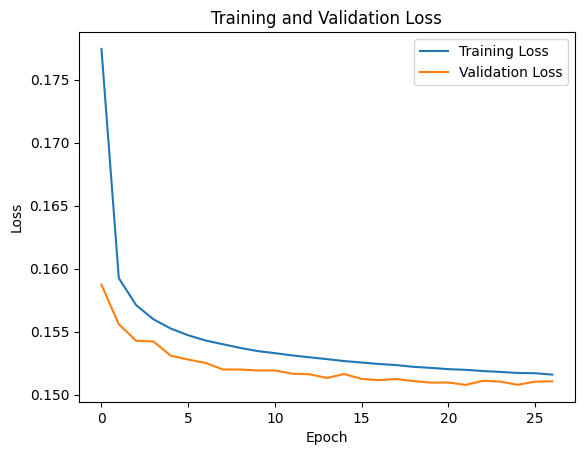

/global/homes/g/gupsingh/.conda/envs/research/lib/python3.11/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


Plot sent successfully: None


In [22]:
#Diagonistic Plot
plt.figure()
plt.plot(history_parametrized.history['loss'], label='Training Loss')
plt.plot(history_parametrized.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
img_path = "plots/parametrized_trainingloss.png"
plt.savefig(img_path)
plt.legend()
plt.show()

from utils import send_slack_plot
send_slack_plot(img_path)

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(X_train_qq, Y_train_qq, epochs=5000,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024,callbacks=[es])

Epoch 1/5000


2024-02-15 14:15:41.134753: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8aaffd7de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 14:15:41.134774: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-15 14:15:41.145433: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 14:15:41.463640: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1708035341.552828  970767 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2662/2662 [==============================] - 16s 4ms/step - loss: 0.2517 - accuracy: 0.9015 - val_loss: 0.2033 - val_accuracy: 0.9239
Epoch 2/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1927 - accuracy: 0.9272 - val_loss: 0.1829 - val_accuracy: 0.9301
Epoch 3/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1773 - accuracy: 0.9318 - val_loss: 0.1718 - val_accuracy: 0.9336
Epoch 4/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1685 - accuracy: 0.9347 - val_loss: 0.1650 - val_accuracy: 0.9360
Epoch 5/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1629 - accuracy: 0.9369 - val_loss: 0.1603 - val_accuracy: 0.9379
Epoch 6/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1587 - accuracy: 0.9386 - val_loss: 0.1566 - val_accuracy: 0.9394
Epoch 7/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1556 - accuracy: 0.9398 - val_loss: 0.1541 - val_a

KeyboardInterrupt: 

In [57]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_normal = Sequential()
model_normal.add(Dense(128, input_dim=8, activation='relu'))
model_normal.add(Dense(128, activation='relu'))
model_normal.add(Dense(128, activation='relu'))
model_normal.add(Dense(1, activation='sigmoid'))
model_normal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_normal = model_normal.fit(X_train_qq, Y_train_qq, epochs = 1000, validation_data=(X_val_qq, Y_val_qq), batch_size=5*1024, callbacks = [es])

Epoch 1/1000
2662/2662 [==============================] - 9s 3ms/step - loss: 0.1617 - accuracy: 0.9368 - val_loss: 0.1434 - val_accuracy: 0.9443
Epoch 2/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1387 - accuracy: 0.9463 - val_loss: 0.1382 - val_accuracy: 0.9466
Epoch 3/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1362 - accuracy: 0.9472 - val_loss: 0.1359 - val_accuracy: 0.9473
Epoch 4/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1351 - accuracy: 0.9475 - val_loss: 0.1344 - val_accuracy: 0.9479
Epoch 5/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1344 - accuracy: 0.9478 - val_loss: 0.1357 - val_accuracy: 0.9473
Epoch 6/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1339 - accuracy: 0.9480 - val_loss: 0.1364 - val_accuracy: 0.9468
Epoch 7/1000
2662/2662 [==============================] - 7s 3ms/step - loss: 0.1335 - accuracy: 0.9481 - val_loss: 0.1341 -

In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94709
best_epoch,41
best_val_loss,0.13607
epoch,41
loss,0.1365
val_accuracy,0.94731


In [15]:
model_qq.save(pscratch_dir + "model_fixed")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_fixed/assets


In [52]:
model_qq.save("pscratch/sd/g/gupsingh/model_fixed_early")

INFO:tensorflow:Assets written to: pscratch/sd/g/gupsingh/model_fixed_early/assets


INFO:tensorflow:Assets written to: pscratch/sd/g/gupsingh/model_fixed_early/assets


In [7]:
#model_qq = tf.keras.models.load_model("model_qq_v2")
#model_qq = tf.keras.models.load_model("model_qq_opt2")
#model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/neat-tree-47")
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
#model_qq = tf.keras.models.load_model("model_qq_noisy10")

In [78]:
qq = 'qq'
noise = False

weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4

w1, w2 = np.round(np.random.uniform(0.5, 6.0, size=2),3)
# w1 = 5
# w2 = 4
# w1, w2 = 4.614, 1.166
#w1, w2 = 1.14297616481781, 1.6546475887298584
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# w1 = 3.095
# w2 = 4.646
# w1 = 0.81
# w2 = 4.223
#sigspace = np.flip(np.logspace(-3,-1,10))
# sigspace = [0.233]
#for sigfrac in sigspace:
initial_learning_rate = 0.1
final_learning_rate = 0.01
decay_epochs = 10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_rate=(final_learning_rate / initial_learning_rate) ** (1.0 / decay_epochs),
    decay_steps=1,
    staircase=True)
lr_schedule = LearningRateScheduler(initial_lr=0.2, patience=10,  min_lr=1e-4)

sigfrac = 0.02
print(w1, w2, sigfrac)

for l in model_qq.layers:
    l.trainable=False

inputs_hold = tf.keras.Input(shape=(1,))
simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
model3 = Model(inputs = inputs_hold, outputs = simple_model)

inputs_hold2 = tf.keras.Input(shape=(1,))
simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(6,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_qq(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
sigfrac2 = 0.1
LLR_xs = 1.+sigfrac2*LLR - sigfrac2
#LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
ws = LLR_xs / (1.+LLR_xs)
model_semiweak = Model(inputs = inputs, outputs = ws)
model_semiweak.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1))

m1 = 3
m2 = 3

test_background = int(1/2 * len(x[0,0, qq, False]))
train_reference = int(1/4 *len(x[0,0, qq, False]))
train_data = int(1/4 * len(x[0,0, qq, False]))
test_signal = int(1/2*len(x[m1,m2, qq, False]))

#fixed signal portion
N = int(1/4 *len(x[0,0, qq, False]))
signal = x[m1,m2, qq, False][test_signal:test_signal+int(sigfrac*N)]
x_data_ = np.concatenate([x[0,0, qq, False][test_background:],signal])
y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

myhistory_hack_ = model_semiweak.fit(X_train_[:,0:6], Y_train_,
                                     epochs=20,validation_data=(X_val_[:,0:6], Y_val_),
                                     batch_size=1024, verbose = 0,
                                     callbacks=[lr_schedule])
print(m1,m2,model_semiweak.trainable_weights[0].numpy()[0][0],model_semiweak.trainable_weights[1].numpy()[0][0])
weight_list1+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
weight_list2+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
#weight_list3+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

2.507 0.748 0.02
3 3 3.0536997 -0.52898556


In [75]:
# #from landscapes import eval_loss_landscape_6Features
# sigspace = [np.logspace(-3, -1, 10)[-1]]
# feature_dims = 6
# params=2
# m1,m2 = 1, 5.5
# step = 0.25
# eval_loss_landscape_6Features(sigspace, model_qq, feature_dims, params, m1, m2, step)

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

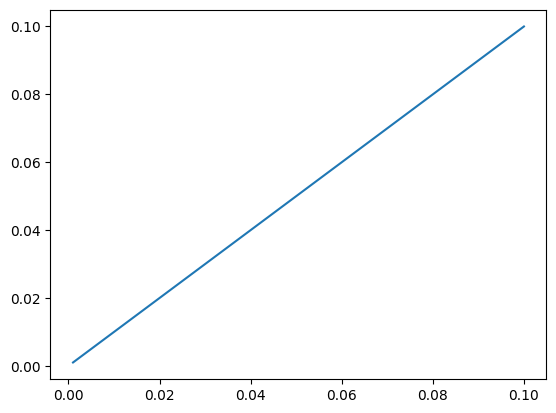

In [76]:
sigspace = np.logspace(-3, -1, 10)
plt.plot(sigspace, sigspace, label = "Theoretical")
plt.plot(sigspace, np.exp(weight_list3), label = "Fitted")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [16]:
# plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
# plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
# plt.xscale("log")
# plt.xlabel("S/B")
# plt.ylabel("Fitted masses [GeV]")
# plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
# plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
# plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
# plt.legend()
# plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

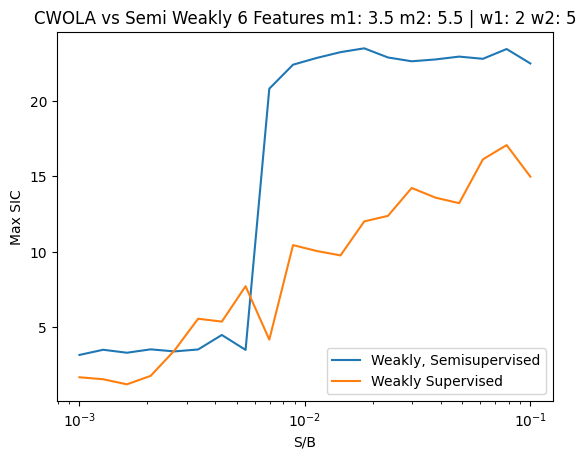

In [213]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

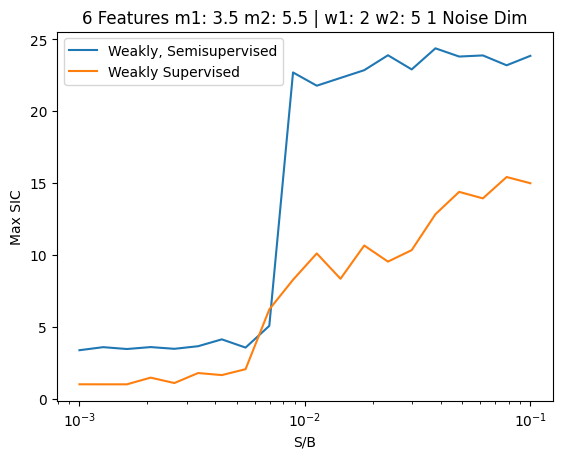

In [455]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 1 Noise Dim")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

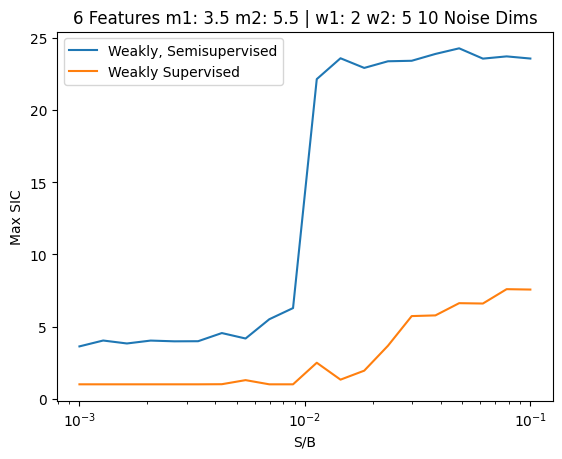

In [39]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 10 Noise Dims")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

In [16]:
#dedicated training on single mass pair
def train_supervised(feature_dims, m1, m2):
    tf.random.set_seed(42)
    np.random.seed(42)
    x_data_full = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
    y_data_full = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
    X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5, random_state = 42, shuffle=False)

    model_dedicated = Sequential()
    model_dedicated.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(1, activation='sigmoid'))
    model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

    history_fullySupervised = model_dedicated.fit(X_train_full, Y_train_full, epochs=100,validation_data=(X_val_full, Y_val_full),batch_size=1024, verbose = 0)
    preds = model_dedicated.predict(X_val_full,batch_size=1000)
    fpr, tpr, _ = metrics.roc_curve(Y_val_full, preds)
    maxsic_full = np.max(tpr/np.sqrt(fpr+epsilon))
    return maxsic_full

#CWOLA comparison
def compileCWOLA(feature_dims, m1, m2):
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cwola

from tensorflow.keras.constraints import Constraint
class WeightConstraint(Constraint):
    def __init__(self, min_value=0.5, max_value=6):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value}
    
# initial_learning_rate = 0.04
# final_learning_rate = 0.01
# decay_epochs = 50

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_rate=(final_learning_rate / initial_learning_rate) ** (1.0 / decay_epochs),
#     decay_steps=1,
#     staircase=True)

#SemiWeak Model
def compileSemiWeakly(sigfrac, model, feature_dims, params, m1, m2, w1, w2):
    
    for l in model.layers:
        l.trainable=False
        
    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    epsilon = 1e-4
    #physics prior
    hidden_layer_1 = model(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)

    if params == 2:
        LLR_xs = 1.+sigfrac*LLR - sigfrac
    elif params == 3:
        LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR - model33(tf.ones_like(inputs)[:,0])
    else:
        print("Choose 2 or 3 parameters")
    ws = LLR_xs / (1.+LLR_xs)

    SemiWeakModel = Model(inputs = inputs, outputs = ws)
    SemiWeakModel.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
    return SemiWeakModel

def compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2):
    #freeze both two pronged and three pronged prior models
    for l in model_qq.layers:
        l.trainable=False

    for l in model_qqq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs_hold4 = tf.keras.Input(shape=(1,))
    simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
    model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    hidden_layer_13 = model_qqq(inputs2)
    LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
    LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
    
    if parameters == 2:
        LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
    if parameters == 4:
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0]) - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
    SemiWeak3Prong = Model(inputs = inputs, outputs = ws)
    SemiWeak3Prong.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))
    return SemiWeak3Prong

In [17]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.

noise = False
epsilon = 1e-4
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations):
    maxsicandstd1 = {}
    maxsicandstd2 = {}
    msic1_runs = []
    msic2_runs = []
    std1_runs = []
    std2_runs = []
    score1_injections_raw_runs = []
    score2_injections_raw_runs = []
    weight_list1_runs = []
    weight_list2_runs = []
    weight_list3_runs = []
    initial_weights_runs = []
    
    qq = "qq"
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    sigspace = np.flip(np.logspace(-3,-1,10))
    for sigfrac in sigspace:

        initial_weights = []

        msic1_median = []
        msic2 = []
        score1_injections = []
        score2_injections = []
        weight_list1_injections = []
        weight_list2_injections = []
        weight_list3_injections = []

        print(f"---------------{sigfrac}---------------")

        # N ~ Poission(M) injected events
        for injection in range(injections):
            print(f"Injecting N = {injections - injection} more times, currently on: N = {injection}")

            #randomized signal
            random_test_signal_length = random.randint(0, test_signal - 1)
            N = int(1/4 * (len(x[0,0, qq, noise])))
            signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

            #fixed signal portion
            # N = int(1/4 * (len(x[0,0, qq, noise])))
            # signal = x[m1, m2, qq, noise][test_signal:test_signal + int(sigfrac*N)]

            score1_kruns = []
            weight_list1_kruns = []
            weight_list2_kruns = []
            weight_list3_kruns = []

            print(f"Ensembling {k_runs} for Signal Fraction : {sigfrac}")
            for k in range(k_runs):

                w1 = round(random.uniform(0.5, 6),3)
                w2 = round(random.uniform(0.5, 6),3)
                initial_weights.append((w1, w2))

                print(f"Initialization: {w1} {w2}")

                for l in model_qq.layers:
                    l.trainable=False
                model_semiweak = compileSemiWeakly(sigfrac,model_qq, feature_dims, params, m1, m2, w1, w2)

                test_background = int(1/2 * len(x[0,0, qq, noise]))
                train_reference = int(1/4 *len(x[0,0, qq, noise]))
                train_data = int(1/4 * len(x[0,0, qq, noise]))
                test_signal = int(1/2*len(x[m1,m2, qq, noise]))

                x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                history_semiweak = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=50,
                                                       validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0, callbacks = [es])

                print(f"m1: {m1}",f"m2: {m2}", f"w1: {model_semiweak.trainable_weights[0].numpy()[0][0]}", f"w2: {model_semiweak.trainable_weights[1].numpy()[0][0]}")

                weight_list1_kruns+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
                weight_list2_kruns+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
                weight_list3_kruns+=[model_semiweak.trainable_weights[2].numpy()[0][0]]

                scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
                #per-event probability
                score1_kruns.append(scores)

            #kruns finished
            weight_list1_injections.append(weight_list1_kruns)
            weight_list2_injections.append(weight_list2_kruns)
            weight_list3_injections.append(weight_list3_kruns)
            
            #now average over the k classifiers runs
            y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr, tpr, _ = metrics.roc_curve(y, np.median(score1_kruns, axis = 0))
            msic1_kmedian = np.max(tpr/np.sqrt(fpr+epsilon))
            score1_injections.append(score1_kruns)
            msic1_median.append(msic1_kmedian)
            print(f" --- msic1_median on injection {injection}: {msic1_kmedian} ---")
            
            #weakly supervised only inject no k classifiers (out of mass initialization loop) no averaging to be done yet
            model_CWOLA = compileCWOLA(feature_dims, m1, m2)
            history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
            
            scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            score2_injections.append(scores2)
            
            y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
            msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
        
        msic1_runs.append(np.median(msic1_median))
        print(f" --- msic1_runs for signal fraction {sigfrac}: {np.median(msic1_median)} ---")
        std1_runs.append(np.std(msic1_median))
        print(f" --- msic1_runs_std for signal fraction {sigfrac}: {np.std(msic1_median)} ---")
        
        print(f" --- msic2_runs for signal fraction {sigfrac}: {np.median(msic2)} ---")
        std2_runs.append(np.std(msic2))
        print(f" --- msic2_runs_std for signal fraction {sigfrac}: {np.std(msic2)} ---")
        msic2_runs.append(np.median(msic2))
        
        score1_injections_raw_runs.append(score1_injections)
        score2_injections_raw_runs.append(score2_injections)
        weight_list1_runs.append(weight_list1_injections)
        weight_list2_runs.append(weight_list2_injections)
        weight_list3_runs.append(weight_list3_injections)
        
        maxsicandstd1[sigfrac] = (np.median(msic1_median), np.std(msic1_median))
        maxsicandstd2[sigfrac] = (np.median(msic2), np.std(msic2))
        np.save(f"data/maxsicandstd1_notebook{float(m1)}{float(m2)}.npy", maxsicandstd1)
        np.save(f"data/maxsicandstd2_notebook{float(m1)}{float(m2)}.npy", maxsicandstd2)

    np.save(f"data/msic1_median_notebook{float(m1)}{float(m2)}.npy", maxsicandstd1)
    np.save(f"data/msic2_median_notebook{float(m1)}{float(m2)}.npy", maxsicandstd2)
    np.save(f"data/std1_median_notebook{float(m1)}{float(m2)}.npy", std1_runs)
    np.save(f"data/std2_median_notebook{float(m1)}{float(m2)}.npy", std2_runs)
    np.save(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}.npy", weight_list1_runs)
    np.save(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}.npy", weight_list2_runs)
    np.save(f"data/weight_list3_runs_notebook{float(m1)}{float(m2)}.npy", weight_list3_runs)
    np.save(f"data/initial_weights_runs_notebook{float(m1)}{float(m2)}.npy", initial_weights_runs)

In [36]:
#fully supervised dedicated training initiaized once
msic_full = train_supervised(6, 5, 1)
print("FS Max Sic: ",msic_full)
#parametrized classifer
scores_parameterized = model_qq.predict(x_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1],batch_size=1000)
fpr_param, tpr_param, _ = metrics.roc_curve(y_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], scores_parameterized)
msic_param = np.max(tpr_param/np.sqrt(tpr_param+epsilon))
print("Parametrized Max Sic: ", msic_param)

In [18]:
#mass initializations
k_runs = 5
feature_dims = 6
params = 3
#number of randomized signal injection
injections = 10

m1 = 3
m2 = 3

parameters = params
m_initializations = k_runs

train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations)

---------------0.1---------------
Injecting N = 10 more times, currently on: N = 0
Ensembling 5 for Signal Fraction : 0.1
Initialization: 1.15 2.061
m1: 3 m2: 3 w1: 3.015413522720337 w2: 3.036273956298828
96/96 [==============================] - 0s 975us/step
Initialization: 4.524 3.118
m1: 3 m2: 3 w1: 3.0122454166412354 w2: 3.0334677696228027
96/96 [==============================] - 0s 966us/step
Initialization: 3.909 0.534
m1: 3 m2: 3 w1: 3.0137386322021484 w2: 0.5
96/96 [==============================] - 0s 931us/step
Initialization: 1.817 3.089


KeyboardInterrupt: 

In [36]:
import time
def eval_loss_landscape(feature_dims, parameters, m1, m2, step, decay):
    qq = decay
    noise = False
    start_time = time.time()
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"data/landscapes/z_{feature_dims}_{parameters}_{m1}{m2}_{step}_{decay}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
        
    losses_list = []
    epsilon = 1e-4
    sigspace = [0.1]
    
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sigfrac in sigspace:
        print("Signal Fraction: ", sigfrac)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 100 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)

                if decay == "qq":
                    for l in model_qq.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)
                    
                if decay == "qqq":
                    for l in model_qqq.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly3Prong(model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                key = (sigfrac,m1,m2, decay)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq, noise]))
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq, noise])))
                signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_semiweak.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print(f"Loss Landscape for m1 = {m1} and m2 = {m2} already exists for {sigfrac} signal fraction and decay {decay}")
        else:
            z[sigfrac, m1, m2, decay] = losses_list
            losses_list = []
            np.save(file_name, z)
    end_time_total = time.time()

    elapsed_time_total = round(end_time_total - start_time, 3)
    print(f"Total elapsed time: {elapsed_time_total} seconds")

In [37]:
eval_loss_landscape(6, 4, 5, 1, 0.25, "qqq")

Signal Fraction:  0.1
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75
reached 4.75 2.75
reached 5.75 4.75
Time taken: 1002.336 seconds
Total elapsed time: 1002.341 seconds


In [39]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
feature_dims = 6
parameters = 3
m1 = 3
m2 = 4.5
step = 0.25
eval_loss_landscape_6Features(model_qq, feature_dims, parameters, m1, m2, step)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5
reached 1.5 2.5
reached 2.5 4.5
reached 3.75 0.75
reached 4.75 2.75
reached 5.75 4.75
Time taken: 1806.609 seconds
Total elapsed time: 1806.61 seconds


In [40]:
def eval_AUC_landscape(feature_dims, parameters, m1, m2, step, decay):
    qq = decay
    noise = False
    
    start_time = time.time()

    #check if AUC dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"data/landscapes/a_{feature_dims}_{parameters}_{m1}{m2}_{step}_{decay}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        a = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        a = {}
    
    AUC_list = []

    epsilon = 1e-4
    sigspace = [0.1]

    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)
    
    for sigfrac in sigspace:
        print("Signal Fraction: ", sigfrac)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 100 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)

                if decay == "qq":
                    for l in model.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly(model, feature_dims, parameters, m1, m2, w1, w2)
                    
                if decay == "qqq":
                    for l in model_qqq.layers:
                        l.trainable=False
                    model_semiweak = compileSemiWeakly3Prong(model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2, decay)
                if key in a:
                    break

                test_background = int(1/2 *len(x[0,0, qq, noise]))
                train_background = int(1/4 * len(x[0,0,qq, noise]))
                train_data = int(1/4 * len(x[0,0,qq, noise]))
                train_reference = int(1/4 * len(x[0,0,qq, noise]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq, noise])))
                signal = x[m1, m2,qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    y_val_pred = model_semiweak.predict(X_val_)
                    auc = roc_auc_score(Y_val_, y_val_pred)
                AUC_list.append(auc)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in a:
            print(f"AUC Landscape for m1 = {m1} and m2 = {m2} already exists for {sigfrac} signal fraction and decay {decay}")
        else:
            a[sigfrac, m1, m2, decay] = AUC_list
            AUC_list = []
            np.save(file_name, a)
    end_time_total = time.time()

    elapsed_time_total = round(end_time_total - start_time, 3)
    print(f"Total elapsed time: {elapsed_time_total} seconds")

In [35]:
from sklearn.metrics import roc_auc_score
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
m1 = 3
m2 = 3
parameters = 3
feature_dims = 6
eval_AUC_landscape_6Features(model_qq, feature_dims, parameters, m1, m2, 0.25)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
reached 0.5 0.5
996/996 [==============================] - 2s 2ms/step
reached 1.5 2.5
996/996 [==============================] - 2s 2ms/step
reached 2.5 4.5
996/996 [==============================] - 3s 3ms/step
reached 3.75 0.75
996/996 [==============================] - 3s 2ms/step
reached 4.75 2.75
996/996 [==============================] - 3s 2ms/step
reached 5.75 4.75
996/996 [==============================] - 3s 3ms/step
Time taken: 1822.279 seconds


In [9]:
model_qq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/model_fixed")
model_qqq = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/breathless-flower-61qqq")

2024-02-23 17:54:25.671599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79099 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:82:00.0, compute capability: 8.0


In [131]:
decay = "qqq"
noise = False
sigmoid = lambda x: 1. / (1. + np.exp(-x))
    
msic1 = []
weight_list1 = []
weight_list2 = []
weight_list3 = []
weight_list4 = []

sigspace = np.logspace(-3, -1, 10)

loss_values = {}

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)
w1, w2 = 1.798, 2.821

for sigfrac in sigspace:
    print(sigfrac, w1, w2)

    #freeze both two pronged and three pronged prior models
    for l in model_qq.layers:
        l.trainable=False

    for l in model_qqq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs_hold4 = tf.keras.Input(shape=(1,))
    simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
    model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

    inputs = tf.keras.Input(shape=(6,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    hidden_layer_13 = model_qqq(inputs2)
    LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
    LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
    #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
    LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0]) - model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
    SemiWeak3Prong = Model(inputs = inputs, outputs = ws)
    SemiWeak3Prong.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3
    
    test_background = int(1/2 * len(x[0,0, decay, noise]))
    train_reference = int(1/4 *len(x[0,0, decay, noise]))
    train_data = int(1/4 * len(x[0,0, decay, noise]))
    test_signal = int(1/2*len(x[m1,m2, decay, noise]))

    #randomize signal events
    random_test_signal_length = random.randint(0, test_signal - 1)
    N = int(1/4 * (len(x[0,0, decay, noise])))
    signal = x[m1, m2, decay, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

    #mix both samples
    # signal_mixed = np.concatenate([x[m1, m2, decay][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
    # background_mixed = np.concatenate([x[0,0,decay][:int(test_background/2)], x[0,0,qq][:int(test_background/2)]])

    x_data_ = np.concatenate([x[0,0,decay, noise][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

    # x_data_mixed = np.concatenate([background_mixed,signal_mixed])
    # y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    history_semiweak3Prong = SemiWeak3Prong.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
    scores = SemiWeak3Prong.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
    loss_values[(min(history_semiweak3Prong.history["loss"]))] = scores
    print(m1,m2,SemiWeak3Prong.trainable_weights[0].numpy()[0][0],SemiWeak3Prong.trainable_weights[1].numpy()[0][0])

    weight_list1+=[SemiWeak3Prong.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[SemiWeak3Prong.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[SemiWeak3Prong.trainable_weights[2].numpy()[0][0]]
    weight_list4+=[SemiWeak3Prong.trainable_weights[3].numpy()[0][0]]

0.001 1.798 2.821


KeyboardInterrupt: 

In [126]:
top_three = sorted(loss_values.items())[:3]
lowest_losses = [x[0] for x in top_three]
top_three_values = [loss_values[loss] for loss in lowest_losses]
score_median = np.median(top_three_values, axis = 0)
score_median

array([[0.47990686],
       [0.479903  ],
       [0.47990263],
       ...,
       [0.52980095],
       [0.66890746],
       [0.96637607]], dtype=float32)

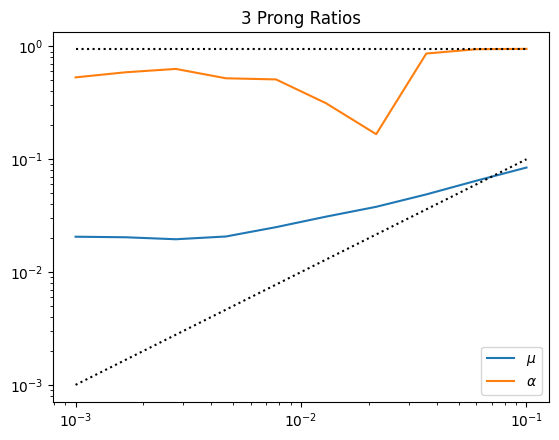

In [57]:
plt.plot(sigspace,np.exp(weight_list3),label=r"$\mu$")
plt.plot(sigspace,sigmoid(np.array(weight_list4)),label=r"$\alpha$")
plt.plot(sigspace,sigspace,ls=":",color="black")
plt.plot(sigspace, [sigmoid(weight_list4[-1])] * 10, ls = ":", color = "black")
plt.title("3 Prong Ratios")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
#fully supervised
scores_full = model_dedicated.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
y_full = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)

In [53]:
x[0,0,qqq, noise][int(test_background/2):]

array([[-1.11881922, -1.66852576,  1.57244427,  1.20983769, -0.13939007,
         0.85941707],
       [-1.12420602, -1.26681214,  0.82536103,  0.1229807 ,  0.30860917,
         0.13311748],
       [-1.14769921, -0.50415523,  1.43958292,  0.62034086,  0.19901901,
        -1.04425623],
       ...,
       [-0.96736856, -1.48238533,  1.25622683, -0.47599974, -0.32423304,
         0.86060971],
       [-1.3598598 , -1.72354998,  1.79953958,  1.20194427,  0.44119858,
         0.28992835],
       [-1.42887276, -1.6890858 ,  0.89151195,  0.58091326,  1.22563292,
         0.4144562 ]])

(0.0, 700.0)

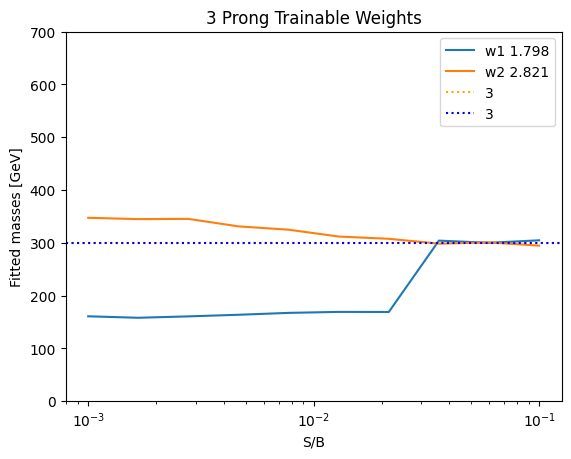

In [58]:
plt.plot(sigspace,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sigspace,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("3 Prong Trainable Weights")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [19]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.
from utils import get_stuck_weights

noise = False
epsilon = 1e-4
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = "qq"):
    maxsicandstd1 = {}
    maxsicandstd2 = {}
    msic1_runs = []
    msic2_runs = []
    std1_runs = []
    std2_runs = []
    score1_injections_raw_runs = []
    score2_injections_raw_runs = []
    weight_list1_runs = []
    weight_list2_runs = []
    weight_list3_runs = []
    weight_list4_runs = []
    initial_weights_runs = []
    
    qq = decay
    test_signal = int(1/2*len(x[m1,m2, qq, noise]))

    sigspace = np.flip(np.logspace(-3,-1,10))
    for sigfrac in sigspace:
        print(f"At {sigfrac} for decay {decay}")

        initial_weights = []

        msic1_median = []
        msic2 = []
        score1_injections = []
        score2_injections = []
        weight_list1_injections = []
        weight_list2_injections = []
        weight_list3_injections = []
        weight_list4_injections = []

        print(f"---------------{sigfrac}---------------")

        # N ~ Poission(M) injected events
        for injection in range(injections):
            print(f"Injecting N = {injections - injection} more times, currently on: N = {injection}")

            #randomized signal
            random_test_signal_length = random.randint(0, test_signal - 1)
            N = int(1/4 * (len(x[0,0, qq, noise])))
            signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

            score1_kruns = []
            weight_list1_kruns = []
            weight_list2_kruns = []
            weight_list3_kruns = []
            weight_list4_kruns = []
            scoreLossdict = {}

            print(f"Ensembling {m_initializations} for Signal Fraction : {sigfrac}")
            for k in range(m_initializations):

                w1 = round(random.uniform(0.5, 6),3)
                w2 = round(random.uniform(0.5, 6),3)
                initial_weights.append((w1, w2))

                print(f"Initialization: {w1} {w2}")

                if decay == "qq":
                    model_semiweak = compileSemiWeakly(sigfrac, model_qq, feature_dims, parameters, m1, m2, w1, w2)

                if decay == "qqq":
                    model_semiweak = compileSemiWeakly3Prong(sigfrac, model_qq, model_qqq, feature_dims, parameters, m1, m2, w1, w2)

                test_background = int(1/2 * len(x[0,0, qq, noise]))
                train_reference = int(1/4 *len(x[0,0, qq, noise]))
                train_data = int(1/4 * len(x[0,0, qq, noise]))
                test_signal = int(1/2*len(x[m1,m2, qq, noise]))

                x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                history_semiweak3prong = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=50,
                                                       validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
                
                print(f"m1: {m1}",f"m2: {m2}", f"w1: {model_semiweak.trainable_weights[0].numpy()[0][0]}", f"w2: {model_semiweak.trainable_weights[1].numpy()[0][0]}")

                weight_list1_kruns+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
                weight_list2_kruns+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
                weight_list3_kruns+=[model_semiweak.trainable_weights[2].numpy()[0][0]]
                
                if decay == "qqq":
                    weight_list4_kruns+=[model_semiweak.trainable_weights[3].numpy()[0][0]]

                scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
                #per-event probability
                score1_kruns.append(scores)
                scoreLossdict[(min(history_semiweak3prong.history["loss"]))] = scores

            #kruns finished
            m1_diff = np.array(weight_list1_kruns) - np.array(np.ones(len(m_initializations)))*m1
            m2_diff = np.array(weight_list2_kruns) - np.array(np.ones(len(m_initializations)))*m2
            
            weight_list1_injections.append(weight_list1_kruns)
            weight_list2_injections.append(weight_list2_kruns)
            weight_list3_injections.append(weight_list3_kruns)
            if decay == "qqq":
                weight_list4_injections.append(weight_list4_kruns)
            
            #now average over the k classifiers runs
            y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            
            #get the lowest scores from dictionary of losses and scores
            top_items = sorted(scoreLossdict.items())[:3]
            lowest_losses = [x[0] for x in top_items]
            top_scores = [scoreLossdict[loss] for loss in lowest_losses]
            fpr, tpr, _ = metrics.roc_curve(y, np.median(top_scores, axis = 0))
            msic1_kmedian = np.max(tpr/np.sqrt(fpr+epsilon))
            score1_injections.append(score1_kruns)
            msic1_median.append(msic1_kmedian)
            print(f" --- msic1_median on injection {injection}: {msic1_kmedian} ---")
            
            #weakly supervised only inject no k classifiers (out of mass initialization loop) no averaging to be done yet
            model_CWOLA = compileCWOLA(feature_dims, m1, m2)
            history_CWOLA = model_CWOLA.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
            
            scores2 = model_CWOLA.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            score2_injections.append(scores2)
            
            y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
            msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
        
        msic1_runs.append(np.median(msic1_median))
        print(f" --- msic1_runs for signal fraction {sigfrac}: {np.median(msic1_median)} ---")
        std1_runs.append(np.std(msic1_median))
        print(f" --- msic1_runs_std for signal fraction {sigfrac}: {np.std(msic1_median)} ---")
        
        print(f" --- msic2_runs for signal fraction {sigfrac}: {np.median(msic2)} ---")
        std2_runs.append(np.std(msic2))
        print(f" --- msic2_runs_std for signal fraction {sigfrac}: {np.std(msic2)} ---")
        msic2_runs.append(np.median(msic2))
        
        score1_injections_raw_runs.append(score1_injections)
        score2_injections_raw_runs.append(score2_injections)
        weight_list1_runs.append(weight_list1_injections)
        weight_list2_runs.append(weight_list2_injections)
        weight_list3_runs.append(weight_list3_injections)
        if decay == "qqq":
            weight_list4_runs.append(weight_list4_injections)
        
        maxsicandstd1[sigfrac] = (np.median(msic1_median), np.std(msic1_median))
        maxsicandstd2[sigfrac] = (np.median(msic2), np.std(msic2))
        np.save(f"data/maxsicandstd1_notebook{float(m1)}{float(m2)}_{decay}.npy", maxsicandstd1)
        np.save(f"data/maxsicandstd2_notebook{float(m1)}{float(m2)}_{decay}.npy", maxsicandstd2)
        
    stuck_weights = get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1, weight_list2, decay)
    np.save(f"data/stuck_weights{float(m1)}{float(m2)}_{decay}.npy", stuck_weights)
    
    np.save(f"data/msic1_median_notebook{float(m1)}{float(m2)}_{decay}.npy", maxsicandstd1)
    np.save(f"data/msic2_median_notebook{float(m1)}{float(m2)}_{decay}.npy", maxsicandstd2)
    np.save(f"data/std1_median_notebook{float(m1)}{float(m2)}_{decay}.npy", std1_runs)
    np.save(f"data/std2_median_notebook{float(m1)}{float(m2)}_{decay}.npy", std2_runs)
    np.save(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", weight_list1_runs)
    np.save(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", weight_list2_runs)
    np.save(f"data/weight_list3_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", weight_list3_runs)
    
    np.save(f"data/score1_injections_raw_runs{float(m1)}{float(m2)}_{decay}.npy", score1_injections_raw_runs)
    np.save(f"data/score2_injections_raw_runs{float(m1)}{float(m2)}_{decay}.npy", score2_injections_raw_runs)
    if decay == "qqq":
        np.save(f"data/weight_list4_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", weight_list4_runs)
    np.save(f"data/initial_weights_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", initial_weights_runs)

In [125]:
def get_stuck_weights(sigspace, injections, m_initializations, m1, m2, weight_list1, weight_list2, decay):
    # weight_list1 = np.load(f"data/weight_list1_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    # weight_list2 = np.load(f"data/weight_list2_runs_notebook{float(m1)}{float(m2)}_{decay}.npy", allow_pickle = True)
    
    missed = {}

    found_one = 0
    found_both = 0
    found_none = 0

    for sigfrac in range(len(sigspace)):

        for injection in range(injections):

            m1_diff = abs(np.array(np.ones(len(weight_list1[sigfrac][injection]))*m1) - np.array(weight_list1[sigfrac][injection]))
            m2_diff = abs(np.array(np.ones(len(weight_list2[sigfrac][injection]))*m2) - np.array(weight_list2[sigfrac][injection]))

            count = 0
            for diff1, diff2 in zip(m1_diff, m2_diff):
                case1 = diff1 > 0.2 and diff2 > 0.2
                case2 = diff1 < 0.2 and diff2 < 0.2
                case3 = diff1 > 0.2 and diff2 < 0.2 or diff1 < 0.2 and diff2 > 0.2

                if case1:
                    found_none+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                elif case2:
                    found_both+=1
                elif case3:
                    found_one+=1
                    missed[(sigspace[sigfrac], injection)] = (weight_list1[sigfrac][injection][count], weight_list2[sigfrac][injection][count])
                    print(np.array(weight_list1[sigfrac][injection][count]), np.array(weight_list2[sigfrac][injection][count]))
                count+=1
                
    print(f"Found Both: {found_both}")
    print(f"Found None: {found_none}")
    print(f"Found One: {found_one}")
            
    return missed

In [56]:
weight_list1[0][0][0]

2.9980147

In [20]:
feature_dims = 6
m1 = 3
m2 = 3
parameters = 3
injections = 10
m_initializations = 5
decay = "qq"
train_semiweak(feature_dims, m1, m2, parameters, injections, m_initializations, decay = decay)

At 0.1 for decay qq
---------------0.1---------------
Injecting N = 10 more times, currently on: N = 0
Ensembling 5 for Signal Fraction : 0.1
Initialization: 4.658 3.285
m1: 3 m2: 3 w1: 2.9980146884918213 w2: 3.0263962745666504
96/96 [==============================] - 0s 926us/step
Initialization: 1.978 2.541
m1: 3 m2: 3 w1: 3.003512144088745 w2: 3.032288074493408
96/96 [==============================] - 0s 980us/step
Initialization: 0.739 4.152
m1: 3 m2: 3 w1: 3.005293130874634 w2: 3.0375330448150635
96/96 [==============================] - 0s 997us/step
Initialization: 1.242 4.919
m1: 3 m2: 3 w1: 3.0058157444000244 w2: 3.035590648651123
96/96 [==============================] - 0s 953us/step
Initialization: 4.087 3.118
m1: 3 m2: 3 w1: 2.99519419670105 w2: 3.0270776748657227
96/96 [==============================] - 0s 946us/step
 --- msic1_median on injection 0: 28.018935908710702 ---
96/96 [==============================] - 0s 700us/step
Injecting N = 9 more times, currently on: N = 1